# Reproducibility in paediatric versus early adults’ groups

This notebook investigates whether different age stages (paediatric versus adults) have different reproducibility behaviour. The age range of the participants is from 6.5 to 56.2 years, and the analysis was carried out for two age groups: paediatric and adults. In this analysis the ABIDE I dataset was used. ABIDE I is a multi-site data sharing initiative (17 sites in total) with neurotypical controls and subjects diagnosed with Autism Spectrum Disorder (ASD). 

In [1]:
#@title

import os
import math
import matplotlib
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import LinearRegression
from utils import get_regression_metrics, bland_altman_plot
from settings import RESOURCE_DIR, ABIDE_MAP_SITES

# Tables format
#%matplotlib qt

pd.set_option('display.float_format', lambda x: f"{x: 0.2e}")

# Visualization format
font = {'size'   : 18}
matplotlib.rc('font', **font)
sns.set_theme(style="whitegrid", font_scale=2)

# Global variables
var_compare = "adult"
template_name = "a2009s"
metric_analysis = "corticalThicknessAverage"
path_csv_cortical_data = "cortical_thicknesss_paediatric_vs_early_adults_groups.csv"

color_pallete = {"ADULT": "#25654B", "PAEDIATRIC": "#C94444"}


var_analyse = ["r_square", "slope", "intercept"]

pipeline1 = "ACPC_CAT12"
pipeline2 = "FREESURFER"

/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#@title

df_names_rois = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_atlas_labels.csv"))
df_areas = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_rois_areas.csv"))

## Data

In [3]:
#@title
df_software_raw = pd.read_csv(os.path.join(RESOURCE_DIR, "data", path_csv_cortical_data), low_memory=False)
df_software_raw.set_index("path", inplace=True)
# Get only the template ROIs
df_software_raw = df_software_raw.loc[df_software_raw.roiName.str[1:].isin(df_names_rois.label.to_list())]

df_software_raw.site = df_software_raw.site.apply(lambda x: ABIDE_MAP_SITES[x])
df_software_raw.head(4)

repositoryName  \
path                                                                
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   

                                                                                  site  \
path                                                                                     
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   

                                                    adult    subjectID  \
path                                                                     
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT  sub-0051475   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT  sub-0051475   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT  sub-0051475   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT  sub-0051475   

                                                    sessionID  run       age  \
path                                                                           
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...          1    1  4.42e+01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...          1    1  4.42e+01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...          1    1  4.42e+01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...          1    1  4.42e+01   

                                                   gender    software  \
path                                                                    
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   MALE  ACPC_CAT12   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   MALE  ACPC_CAT12   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   MALE  ACPC_CAT12   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   MALE  ACPC_CAT12   

                                                                     roiName  \
path                                                                           
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  lG_Ins_lg_and_S_cent_ins   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...       lG_and_S_cingul-Ant   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   lG_and_S_cingul-Mid-Ant   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  lG_and_S_cingul-Mid-Post   

                                                    corticalThicknessAverage  \
path                                                                           
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                  3.01e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                  3.11e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                  2.94e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                  2.73e+00   

                                                   template  \
path                                                          
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s   

                                                                        repository_and_site  \
path                                                                                          
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/C

### Check preprocessing problems

Some images were only ran by one of the softwares, in the code below images with preprocessing problems are discoved, and those subjects/session/run are removed from the analysis.

In [4]:
#@title
roi_name = df_software_raw.loc[(~df_software_raw[metric_analysis].isna()) & (df_software_raw.template == template_name)].roiName.to_list()[1]

df_group = df_software_raw[df_software_raw["roiName"] == roi_name].copy()
df_group = df_group[df_group.template == template_name].groupby(by=['path']).apply(lambda x: list(x["software"]))

# Get the images run by only one
df_problems_running = df_group[df_group.apply(len) == 1].to_frame()


software_problems = [item for sublist in df_problems_running[0].to_list() for item in sublist]


print("\n".join([f"{number_problems} images were only processed by: {soft_name}" for soft_name, number_problems in Counter(software_problems).items()]))

2 images were only processed by: ACPC_CAT12
3 images were only processed by: FREESURFER


#### Exclude the subjects only run by only one software

In [5]:
#@title
df_software_raw = df_software_raw[~df_software_raw.index.isin(df_problems_running.index)]

### Demographics

In [6]:
#@title
df_subjects = df_software_raw[["repositoryName", "site", var_compare, "repository_and_site", "subjectID", "sessionID", "run", "age", "gender", "snr_total"]].drop_duplicates().copy()
df_subjects.site = df_subjects.site.apply(lambda x: "" if type(x)==float else x)

if len(df_subjects["repositoryName"].unique()) == 1: 
    groupby_col = ["site"] 
else:
    groupby_col = ["repositoryName", "site"]
    
df_summary = df_subjects.groupby(groupby_col).apply(lambda x: pd.Series({"Total of participants": len(x), 
                                                                         "Number males": (x["gender"]=="MALE").sum(),
                                                                         "Mean and standard deviation [years]": f"{x['age'].mean(): 0.2f}+/-{x['age'].std(): 0.2f}",
                                                                         "Min Age [years]": f"{x['age'].min(): 0.2f}",
                                                                         "Max Age [years]": f"{x['age'].max(): 0.2f}"}))


df_summary

Total of participants  \
site                                                                   
California Institute of Technology                                19   
Carnegie Mellon University                                        13   
Kennedy Krieger Institute                                         33   
Ludwig Maximilians University Munich                              32   
NYU Langone Medical Center                                       104   
Olin Institute of Living at Hartford Hospital                     16   
Oregon Health and Science University                              15   
San Diego State University                                        22   
Social Brain Lab                                                  15   
Stanford University                                               19   
Trinity Centre for Health Sciences                                25   
University of California Los Angeles                              45   
University of Leuven                                              35   
University of Michigan                                            75   
University of Pittsburgh School of Medicine                       27   
University of Utah School of Medicine                             43   
Yale Child Study Center                                           28   

                                               Number males  \
site                                                          
California Institute of Technology                       15   
Carnegie Mellon University                               10   
Kennedy Krieger Institute                                24   
Ludwig Maximilians University Munich                     28   
NYU Langone Medical Center                               78   
Olin Institute of Living at Hartford Hospital            14   
Oregon Health and Science University                     15   
San Diego State University                               16   
Social Brain Lab                                         15   
Stanford University                                      15   
Trinity Centre for Health Sciences                       25   
University of California Los Angeles                     39   
University of Leuven                                     30   
University of Michigan                                   58   
University of Pittsburgh School of Medicine              23   
University of Utah School of Medicine                    43   
Yale Child Study Center                                  20   

                                              Mean and standard deviation [years]  \
site                                                                                
California Institute of Technology                                 28.87+/- 11.21   
Carnegie Mellon University                                          26.85+/- 5.74   
Kennedy Krieger Institute                                           10.16+/- 1.26   
Ludwig Maximilians University Munich                                26.19+/- 9.96   
NYU Langone Medical Center                                          15.83+/- 6.28   
Olin Institute of Living at Hartford Hospital                       16.94+/- 3.68   
Oregon Health and Science University                                10.06+/- 1.08   
San Diego State University                                          14.22+/- 1.90   
Social Brain Lab                                                    33.73+/- 6.61   
Stanford University                                                  9.97+/- 1.64   
Trinity Centre for Health Sciences                                  17.08+/- 3.77   
University of California Los Angeles                                12.96+/- 1.92   
University of Leuven                                                18.17+/- 4.99   
University of Michigan                                              14.82+/- 3.62   
University of Pittsburgh School of Medicine                         18.88+/- 6.64   
University of Utah School of Medici

In [7]:
#@title
df_software = df_software_raw.reset_index().pivot(['path',  'subjectID', 'sessionID', 'run', 'template', var_compare,'roiName'], ['software'], [metric_analysis]).reset_index().set_index("path")
df_software.head(4)

subjectID sessionID run  \
software                                                                        
path                                                                            
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051475         1   1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051475         1   1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051475         1   1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051475         1   1   

                                                   template  adult  \
software                                                             
path                                                                 
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   a2009s  ADULT   

                                                                     roiName  \
software                                                                       
path                                                                           
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  lG_Ins_lg_and_S_cent_ins   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...       lG_and_S_cingul-Ant   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   lG_and_S_cingul-Mid-Ant   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  lG_and_S_cingul-Mid-Post   

                                                   corticalThicknessAverage  \
software                                                         ACPC_CAT12   
path                                                                          
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                 3.01e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                 3.11e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                 2.94e+00   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...                 2.73e+00   

                                                               
software                                           FREESURFER  
path                                                           
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   3.14e+00  
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   3.02e+00  
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   2.73e+00  
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   2.60e+00

### Search subjects with at least one ROI

In [8]:
#@title
df_rois_nan = df_software.loc[df_software[[('corticalThicknessAverage', 'FREESURFER'), ('corticalThicknessAverage', 'ACPC_CAT12')]].isna().sum(axis=1)>0]
df_rois_nan

Empty DataFrame
Columns: [(subjectID, ), (sessionID, ), (run, ), (template, ), (adult, ), (roiName, ), (corticalThicknessAverage, ACPC_CAT12), (corticalThicknessAverage, FREESURFER)]
Index: []

#### Exclude subjects with at least one ROI

In [9]:
#@title
df_software_raw = df_software_raw.loc[~df_software_raw.index.isin(df_rois_nan.index.get_level_values(0).to_list())]
df_software = df_software.loc[~df_software.index.isin(df_rois_nan.index.get_level_values(0).to_list())]

## Analysis

### Overall Analysis

#### Bland-Altman plot

In [10]:
from IPython.display import display, HTML

for var_value in df_software[var_compare].unique():
    df_soft_filter = df_software.loc[df_software[var_compare] == var_value]
    diff = (df_soft_filter[("corticalThicknessAverage", "FREESURFER")] - df_soft_filter[("corticalThicknessAverage", "ACPC_CAT12")])
    test = pg.ttest(diff, 0)


    df_means_diff = df_soft_filter[[("corticalThicknessAverage", "FREESURFER"), 
                                    ("corticalThicknessAverage", "ACPC_CAT12")]].mean().to_frame().T.rename(columns={"corticalThicknessAverage": "Cortical Thickness Average Mean"})
    df_means_diff["Difference FREESURFER - CAT12"] = diff.mean()
    
    
    test = pg.ttest(diff, 0)
    display(HTML(f"<br><h5>{var_value}</h5>"))
    display(HTML(df_means_diff.to_html()))
    
    display(HTML(f"<br><p>One sample t-test to verify whether the means difference is equal to zero</p>"))
    display(HTML(test.to_html()))
    print(f"Confidence interval (95%) of the means difference: [{round(diff.mean() - 1.96*diff.std(), 3)};{round(diff.mean() + 1.96*diff.std(), 3)}]")


Confidence interval (95%) of the means difference: [-0.444;0.512]


/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)
/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


Confidence interval (95%) of the means difference: [-0.498;0.658]


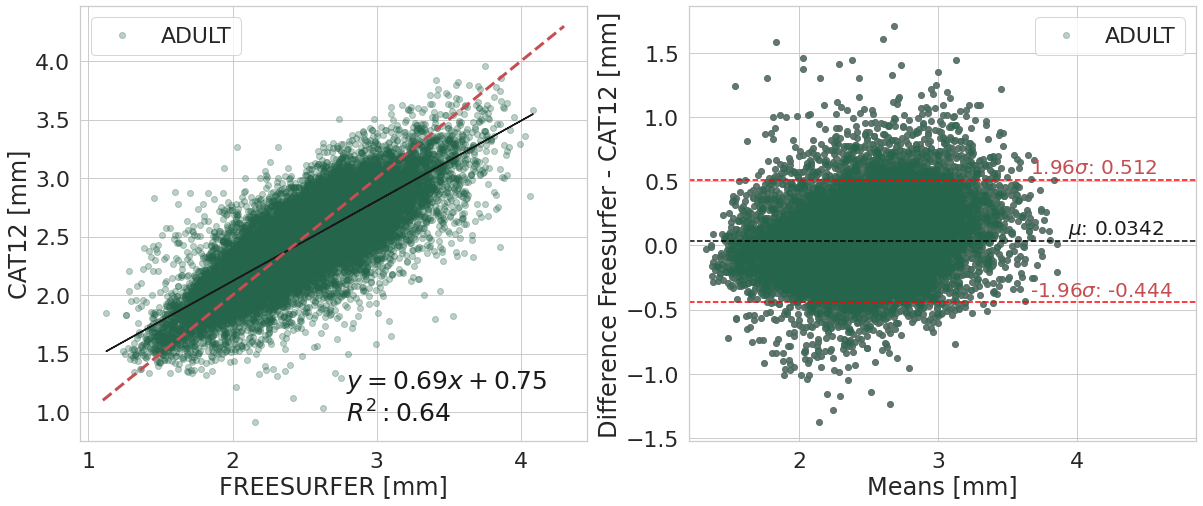

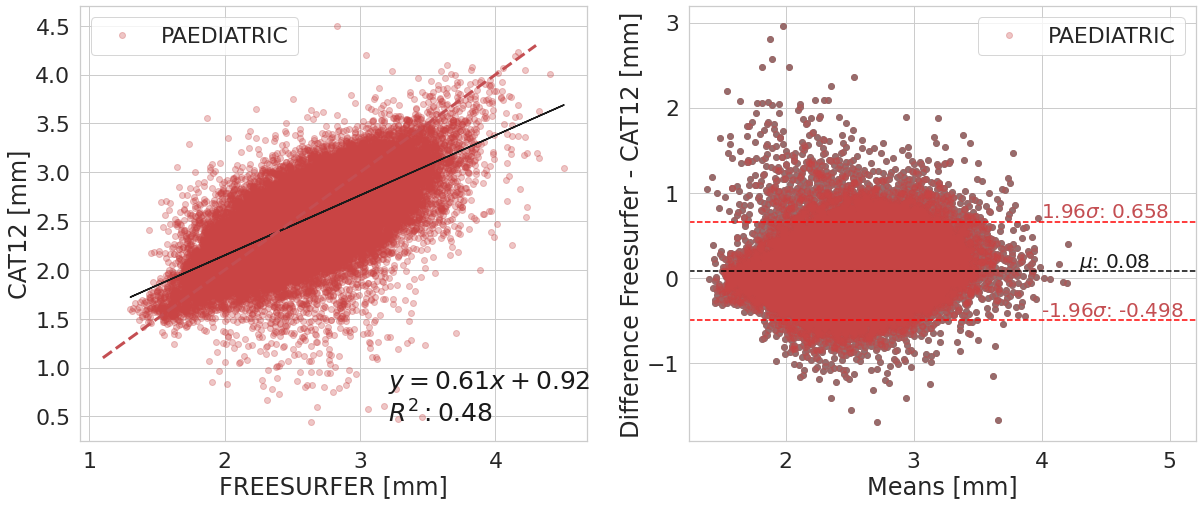

In [11]:
#@title
y_label_txt = "Difference Freesurfer - CAT12 [mm]"

for var in df_software[var_compare].unique():
    df_filt = df_software.loc[df_software[var_compare] == var]
    bland_altman_plot(df_filt.copy().reset_index(),
                      ('corticalThicknessAverage', 'FREESURFER'), 
                      ('corticalThicknessAverage', 'ACPC_CAT12'),
                      var_compare, color_pallete, x_label_reg="FREESURFER [mm]", y_label_reg="CAT12 [mm]",
                      y_label_diff="Difference Freesurfer - CAT12 [mm]")


In [12]:
#@title

df = df_software.reset_index().set_index(["subjectID", "sessionID", "run"]).join(df_subjects.reset_index().set_index(["subjectID", "sessionID", "run"]))
df.columns = ["".join(el) for el in df.columns]
df.head(3)

/tmp/ipykernel_23891/928943096.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df = df_software.reset_index().set_index(["subjectID", "sessionID", "run"]).join(df_subjects.reset_index().set_index(["subjectID", "sessionID", "run"]))


path  \
subjectID   sessionID run                                                      
sub-0050030 1         1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   
                      1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   
                      1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   

                          template  adult                   roiName  \
subjectID   sessionID run                                             
sub-0050030 1         1     a2009s  ADULT  lG_Ins_lg_and_S_cent_ins   
                      1     a2009s  ADULT       lG_and_S_cingul-Ant   
                      1     a2009s  ADULT   lG_and_S_cingul-Mid-Ant   

                           corticalThicknessAverageACPC_CAT12  \
subjectID   sessionID run                                       
sub-0050030 1         1                              3.43e+00   
                      1                              2.62e+00   
                      1                              3.05e+00   

                           corticalThicknessAverageFREESURFER  \
subjectID   sessionID run                                       
sub-0050030 1         1                              2.96e+00   
                      1                              2.57e+00   
                      1                              2.79e+00   

                                                                        path  \
subjectID   sessionID run                                                      
sub-0050030 1         1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   
                      1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   
                      1    ABIDE_I/UniversityofPittsburghSchoolofMedicine...   

                          repositoryName  \
subjectID   sessionID run                  
sub-0050030 1         1          ABIDE_I   
                      1          ABIDE_I   
                      1          ABIDE_I   

                                                                  site  adult  \
subjectID   sessionID run                                                       
sub-0050030 1         1    University of Pittsburgh School of Medicine  ADULT   
                      1    University of Pittsburgh School of Medicine  ADULT   
                      1    University of Pittsburgh School of Medicine  ADULT   

                                                      repository_and_site  \
subjectID   sessionID run                                                   
sub-0050030 1         1    ABIDE_I|UniversityofPittsburghSchoolofMedicine   
                      1    ABIDE_I|UniversityofPittsburghSchoolofMedicine   
                      1    ABIDE_I|UniversityofPittsburghSchoolofMedicine   

                                age gender  snr_total  
subjectID   sessionID run                              
sub-0050030 1         1    2.51e+01   MALE   1.23e+01  
                      1    2.51e+01   MALE   1.23e+01  
                      1    2.51e+01   MALE   1.23e+01

### Participant Analysis

In [13]:
#@title
print(f'Number of subjects in this analysis is: {len(df_software.reset_index()["subjectID"].unique())}')

Number of subjects in this analysis is: 566


#### Compute metrics 

In [14]:
#@title

sub_grouped_by, sub_grouped_by_stats = get_regression_metrics(df_software, ['path'], (metric_analysis, pipeline1), (metric_analysis, pipeline2))

df_ct = df_software.reset_index()[["path", var_compare, "roiName", "corticalThicknessAverage"]].melt(id_vars=["path", var_compare, "roiName"])

all_subjects_icc = []

for path_sub in df_ct["path"].unique():
    df_icc_roi = pg.intraclass_corr(data=df_ct.loc[df_ct["path"] == path_sub], 
                                    targets='roiName', raters='software',
                                    ratings='value')
    df_icc_roi["path"] = path_sub

    all_subjects_icc.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])

df_icc_sub = pd.concat(all_subjects_icc).set_index("path")

df_subject_info = df_subjects.reset_index().set_index(['path']).join(sub_grouped_by_stats).join(df_icc_sub[["ICC"]])
df_subject_info = df_subject_info[~df_subject_info["slope"].isna()]

df_subject_info.head(5)


repositoryName  \
path                                                                
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...        ABIDE_I   

                                                                                  site  \
path                                                                                     
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  California Institute of Technology   

                                                    adult  \
path                                                        
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ADULT   

                                                                        repository_and_site  \
path                                                                                          
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  ABIDE_I|CaliforniaInstituteofTechnology   

                                                      subjectID  sessionID  \
path                                                                         
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051475          1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051476          1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051477          1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051478          1   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...  sub-0051479          1   

                                                    run       age  gender  \
path                                                                        
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...    1  4.42e+01    MALE   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...    1  3.93e+01    MALE   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...    1  4.25e+01    MALE   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...    1  1.97e+01    MALE   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...    1  2.00e+01  FEMALE   

                                                    snr_total     slope  \
path                                                                      
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   1.52e+01  7.74e-01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   1.64e+01  9.63e-01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   1.60e+01  8.36e-01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   1.56e+01  9.04e-01   
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   1.52e+01  9.14e-01   

                                                    intercept   r_value  \
path                                                                      
ABIDE_I/CaliforniaInstituteofTechnology/sub-005...   7.09e-01  8.12e-01   
ABID

#### Reproducibility metrics analysis

In [15]:
#@title
df_subject_info.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                   f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}'], 
                                                                   index=['ICC', '$R^2$']))

ICC          $R^2$
adult                                   
ADULT        0.79+/- 0.06   0.64+/- 0.09
PAEDIATRIC   0.69+/- 0.11   0.51+/- 0.14

#### Analysis of age effect on reproducibility metrics

In [16]:
def latex_float(float_str):
    
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

<IPython.core.display.Math object>

<IPython.core.display.Math object>

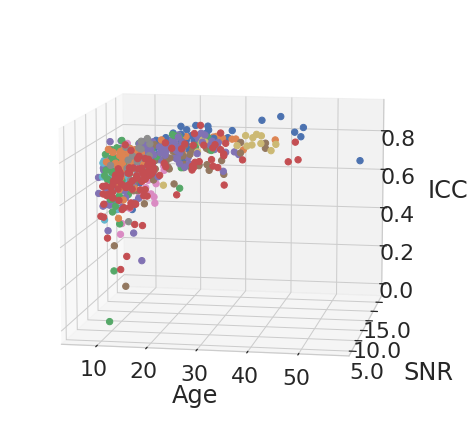

<IPython.core.display.Math object>

<IPython.core.display.Math object>

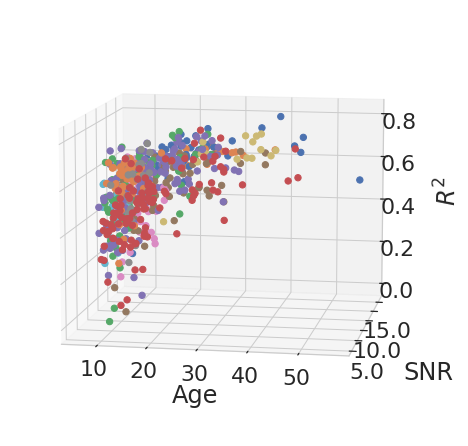

In [17]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import display, Math


reproducibility_measures = [("ICC", "ICC"), ("r_square", "$R^2$")]

for rep_measure, label_measure in reproducibility_measures:
    
    for el in df_subject_info[var_compare].unique():
        legend = el

        data_filtered = df_subject_info.loc[df_subject_info[var_compare] == el]
                
        x_values = data_filtered[["age", "snr_total"]]
        y_values = data_filtered[rep_measure]
        
        model = LinearRegression().fit(x_values, y_values)

        
        age_weight = latex_float(f'{model.coef_[0]: 0.1e}')
        SNR_weight = latex_float(f'{model.coef_[1]: 0.1e}')
        intercept = latex_float(f'{model.intercept_: 0.1e}')
        
        eq = f'${label_measure.replace("$", "")}_' + "{" + legend + "}" + f'={age_weight}age + {SNR_weight}SNR + {intercept}$'
        display(Math(r'{}'.format(eq)))
        
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

        
    for el in df_subject_info["site"].unique():

        df_filt = df_subject_info.loc[df_subject_info["site"] == el]
        x= df_filt["age"].values
        y= df_filt["snr_total"].values
        z= df_filt[rep_measure].values
        # axes instance

        # get colormap from seaborn
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

        # plot
        sc = ax.scatter(x, y, z, s=40, marker='o', cmap=cmap, alpha=1)

    ax.set_xlabel('Age', labelpad=15)
    ax.set_ylabel('SNR', labelpad=30)
    ax.set_zlabel(label_measure, labelpad=30)
    
    for label in ax.get_yaxis().get_ticklabels()[::2]:
        label.set_visible(False)
    ax.view_init(elev=10., azim=-80)

    plt.subplots_adjust(bottom=0.2, top=2)
    plt.setp(ax.get_yticklabels(), rotation=0)

    plt.show()
    

### ROI Analysis


In [18]:
#@title
roi_grouped_by, roi_grouped_by_stats = get_regression_metrics(df_software, ["roiName", var_compare], (metric_analysis, pipeline1), (metric_analysis, pipeline2))

all_rois = []

for var in df_ct[var_compare].unique():
    for roi_name in df_ct["roiName"].unique():
        df_icc_roi = pg.intraclass_corr(data=df_ct.loc[(df_ct["roiName"] == roi_name) & (df_ct[var_compare] == var)], 
                                        targets='path', raters='software',
                                        ratings='value')
        df_icc_roi["roiName"] = roi_name
        df_icc_roi[var_compare] = var
        
        all_rois.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])
        
df_icc_rois = pd.concat(all_rois)


roi_grouped_by_stats = roi_grouped_by_stats.join(pd.concat(all_rois).set_index(["roiName", var_compare])[["ICC", "CI95%"]])


map_abbrev_to_name = df_names_rois.set_index("label")[["name"]].to_dict("series")["name"]
hem_label = {"r": "Right", "l": "Left"}

roi_grouped_by_stats["name"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: map_abbrev_to_name[x[1:]])
roi_grouped_by_stats["hem"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: hem_label[x[0].lower()])


dfs = []

rois_info = roi_grouped_by_stats.copy()
rois_info["label"] = roi_grouped_by_stats.index.get_level_values(0).str[1:].str.strip()
rois_info["hem"] = roi_grouped_by_stats.index.get_level_values(0).str[0]
rois_info = rois_info.reset_index().set_index(["label", "hem", var_compare])

for var in rois_info.index.get_level_values(2).unique():
    for hem in rois_info.index.get_level_values(1).unique():
        df_areas_metrics_var = pd.concat([df_areas, df_areas["Label"].apply(lambda x: rois_info.loc[(x, hem, var)])], axis=1)
        df_areas_metrics_var[var_compare] = var
        dfs.append(df_areas_metrics_var)
        
df_areas_metrics = pd.concat(dfs)
df_areas_metrics["hem"] = df_areas_metrics["roiName"].str[0]


df_icc = df_areas_metrics.pivot_table(index="name", columns=[var_compare, "hem"], values=["ICC"])

df_ci = df_areas_metrics.pivot_table(index="name", columns=[var_compare, "hem"], values=["CI95%"])

df_ci_icc = df_icc.join(df_ci) 
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 2)
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 1)
df_ci_icc = df_ci_icc[[df_ci_icc.columns[0], df_ci_icc.columns[-4], 
                     df_ci_icc.columns[1], df_ci_icc.columns[-3], 
                     df_ci_icc.columns[2], df_ci_icc.columns[-2], 
                     df_ci_icc.columns[3], df_ci_icc.columns[-1]]] 

roi_grouped_by_stats

slope  intercept   r_value   p_value  \
roiName                  adult                                                 
lG_Ins_lg_and_S_cent_ins ADULT       4.62e-01   1.68e+00  5.13e-01  1.34e-13   
                         PAEDIATRIC  2.59e-01   2.34e+00  4.21e-01  6.50e-18   
lG_and_S_cingul-Ant      ADULT       4.65e-01   1.46e+00  5.08e-01  2.36e-13   
                         PAEDIATRIC  4.36e-01   1.60e+00  4.16e-01  1.64e-17   
lG_and_S_cingul-Mid-Ant  ADULT       6.04e-01   9.65e-01  6.61e-01  3.11e-24   
...                                       ...        ...       ...       ...   
rS_temporal_inf          PAEDIATRIC  5.48e-01   1.12e+00  3.89e-01  2.54e-15   
rS_temporal_sup          ADULT       7.52e-01   5.71e-01  7.86e-01  1.99e-39   
                         PAEDIATRIC  6.82e-01   8.02e-01  6.52e-01  7.49e-48   
rS_temporal_transverse   ADULT       8.75e-01   4.57e-01  6.37e-01  4.40e-22   
                         PAEDIATRIC  3.11e-01   1.88e+00  3.06e-01  8.60e-10   

                                      std_err  r_square       ICC  \
roiName                  adult                                      
lG_Ins_lg_and_S_cent_ins ADULT       5.77e-02  2.63e-01  5.10e-01   
                         PAEDIATRIC  2.86e-02  1.77e-01  3.76e-01   
lG_and_S_cingul-Ant      ADULT       5.88e-02  2.58e-01  5.06e-01   
                         PAEDIATRIC  4.88e-02  1.73e-01  4.16e-01   
lG_and_S_cingul-Mid-Ant  ADULT       5.11e-02  4.37e-01  6.58e-01   
...                                       ...       ...       ...   
rS_temporal_inf          PAEDIATRIC  6.64e-02  1.51e-01  3.67e-01   
rS_temporal_sup          ADULT       4.41e-02  6.18e-01  7.85e-01   
                         PAEDIATRIC  4.06e-02  4.25e-01  6.51e-01   
rS_temporal_transverse   ADULT       7.90e-02  4.05e-01  6.06e-01   
                         PAEDIATRIC  4.95e-02  9.39e-02  3.06e-01   

                                            CI95%  \
roiName                  adult                      
lG_Ins_lg_and_S_cent_ins ADULT       [0.39, 0.61]   
                         PAEDIATRIC  [0.29, 0.46]   
lG_and_S_cingul-Ant      ADULT       [0.39, 0.61]   
                         PAEDIATRIC   [0.33, 0.5]   
lG_and_S_cingul-Mid-Ant  ADULT       [0.57, 0.73]   
...                                           ...   
rS_temporal_inf          PAEDIATRIC  [0.28, 0.45]   
rS_temporal_sup          ADULT       [0.72, 0.84]   
                         PAEDIATRIC  [0.59, 0.71]   
rS_temporal_transverse   ADULT       [0.51, 0.69]   
                         PAEDIATRIC  [0.21, 0.39]   

                                                                                  name  \
roiName                  adult                                                           
lG_Ins_lg_and_S_cent_ins ADULT       Long insular gyrus and central sulcus of the i...   
                         PAEDIATRIC  Long insular gyrus and central sulcus of the i...   
lG_and_S_cingul-Ant      ADULT        Anterior part of the cingulate gyrus and sulcus    
                         PAEDIATRIC   Anterior part of the cingulate gyrus and sulcus    
lG_and_S_cingul-Mid-Ant  ADULT       Middle-anterior part of the cingulate gyrus an...   
...                                                                                ...   
rS_temporal_inf          PAEDIATRIC                           Inferior temporal sulcus   
rS_temporal_sup          ADULT                               Superior temporal sulcus    
                         PAEDIATRIC                          Superior temporal sulcus    
rS_temporal_transverse   ADULT                              Transverse temporal sulcus   
                         PAEDIATRIC                         Transverse temporal sulcus   

                                       hem  
roiName                  adult              
lG_Ins_lg_and_S_cent_ins ADULT        Left  
                         PAEDIATRIC   Left  
lG_and_S_cingul-Ant      ADULT        Left  
               

In [19]:
#@title
df_sorted = pd.pivot_table(roi_grouped_by_stats.reset_index(), index="name", values=["r_square"], columns=[var_compare, "hem"])
df_sorted

r_square            \
adult                                                  ADULT             
hem                                                     Left     Right   
name                                                                     
Angular gyrus                                       3.56e-01  4.28e-01   
Anterior occipital sulcus and preoccipital notch    4.29e-01  4.40e-01   
Anterior part of the cingulate gyrus and sulcus     2.58e-01  1.50e-01   
Anterior segment of the circular sulcus of the ...  9.09e-02  1.62e-01   
Anterior transverse collateral sulcus               6.69e-02  6.02e-02   
...                                                      ...       ...   
Temporal pole                                       3.04e-01  2.76e-01   
Transverse frontopolar gyri and sulci               3.84e-01  4.27e-01   
Transverse temporal sulcus                          4.81e-01  4.05e-01   
Triangular part of the inferior frontal gyrus       3.83e-01  3.92e-01   
Vertical ramus of the anterior segment of the l...  1.62e-01  1.22e-01   

                                                                         
adult                                              PAEDIATRIC            
hem                                                      Left     Right  
name                                                                     
Angular gyrus                                        3.94e-01  4.06e-01  
Anterior occipital sulcus and preoccipital notch     2.98e-01  2.61e-01  
Anterior part of the cingulate gyrus and sulcus      1.73e-01  1.60e-01  
Anterior segment of the circular sulcus of the ...   1.85e-01  1.25e-01  
Anterior transverse collateral sulcus                1.67e-02  7.26e-02  
...                                                       ...       ...  
Temporal pole                                        4.37e-01  5.09e-01  
Transverse frontopolar gyri and sulci                3.06e-01  2.96e-01  
Transverse temporal sulcus                           3.32e-01  9.39e-02  
Triangular part of the inferior frontal gyrus        3.82e-01  2.76e-01  
Vertical ramus of the anterior segment of the l...   1.47e-01  1.29e-01  

[74 rows x 4 columns]

#### Reproducibility metrics analysis

In [20]:
#@title
roi_grouped_by_stats.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                        f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}'], 
                                                                        index=['ICC', '$R^2$']))


ICC          $R^2$
adult                                   
ADULT        0.59+/- 0.15   0.38+/- 0.16
PAEDIATRIC   0.52+/- 0.14   0.30+/- 0.14

In [21]:
df_roi_t = roi_grouped_by_stats.reset_index()

for var in ["r_square","ICC"]:

    df_result = pg.ttest(df_roi_t.loc[df_roi_t[var_compare] == "PAEDIATRIC"][var], 
                         df_roi_t.loc[df_roi_t[var_compare] == "ADULT"][var])
    
    display(HTML(f"<br><h5>{var}</h5>"))
    display(HTML(df_result.to_html()))
    

##### Mean per lobe

In [22]:
#@title

to_group_by = ["Area"]
df_areas_metrics_grouped = df_areas_metrics.groupby(to_group_by + [var_compare, "hem"]).mean()
df_lobes = pd.pivot_table(df_areas_metrics_grouped.reset_index(), index=to_group_by, values=["r_square"], columns=[var_compare])

df_lobes

r_square           
adult                             ADULT PAEDIATRIC
Area                                              
 Frontal Lobe                  3.47e-01   2.82e-01
 Insula                        2.42e-01   1.58e-01
 Limbic lobe                   3.65e-01   2.69e-01
 Parietal lobe                 4.91e-01   4.07e-01
 Temporal and occipital lobes  4.14e-01   3.08e-01

#### Paired t-test

In [23]:
all_df = []
for var in df_ct[var_compare].unique():
    for roiname in df_ct['roiName'].unique():
        df_posthoc = pg.pairwise_ttests(data=df_ct.loc[(df_ct['roiName'] == roiname) & (df_ct[var_compare] == var)], 
                                        dv='value', within='software', subject='path',
                                     parametric=True, padjust='fdr_bh', effsize='cohen')

        # Pretty printing of table
        df_posthoc['roiName'] = roiname
        df_posthoc[var_compare] = var
        all_df.append(df_posthoc)
df_f_p_value = pd.concat(all_df)
df_f_p_value.head(4)

Contrast           A           B  Paired  Parametric         T       dof  \
0  software  ACPC_CAT12  FREESURFER    True        True -5.27e+00  1.81e+02   
0  software  ACPC_CAT12  FREESURFER    True        True -2.17e+00  1.81e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  1.21e+01  1.81e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  3.18e+00  1.81e+02   

  alternative     p-unc       BF10     cohen                   roiName  adult  
0   two-sided  3.87e-07  2.789e+04 -3.87e-01  lG_Ins_lg_and_S_cent_ins  ADULT  
0   two-sided  3.16e-02       0.81 -1.60e-01       lG_and_S_cingul-Ant  ADULT  
0   two-sided  4.82e-25   7.93e+21  7.41e-01   lG_and_S_cingul-Mid-Ant  ADULT  
0   two-sided  1.73e-03     10.574  1.59e-01  lG_and_S_cingul-Mid-Post  ADULT

In [24]:
df_f_p_value["hem"] = df_f_p_value.apply(lambda x: hem_label[x.roiName[0].lower()], axis=1)
df_f_p_value["name"] = df_f_p_value.apply(lambda x: map_abbrev_to_name[x.roiName[1:]], axis=1)

# Bonferroni correction
significance_level = .05

df_f_p_value["p-value"] = df_f_p_value["p-unc"].apply(lambda x: min(x*df_f_p_value.shape[0], 1))
df_f_p_value_rejected = df_f_p_value[df_f_p_value["p-value"] < significance_level]

df_f_p_value["cohen"] = df_f_p_value["cohen"].astype(float).round(2).abs()
df_f_p_value["cohen-p-value"] = df_f_p_value[["p-value", "cohen"]].apply(lambda x: f'{x["cohen"]}*' if x['p-value'] < significance_level else f'{x["cohen"]}', axis=1).astype(str)


df_p_value = pd.pivot_table(df_f_p_value.reset_index(), index="name", values=["cohen-p-value"], columns=[var_compare, "hem"], aggfunc=lambda x: ' '.join(x))
df_p_value


cohen-p-value         \
adult                                                      ADULT          
hem                                                         Left  Right   
name                                                                      
Angular gyrus                                              0.45*  0.73*   
Anterior occipital sulcus and preoccipital notch            0.08   0.02   
Anterior part of the cingulate gyrus and sulcus             0.16    0.2   
Anterior segment of the circular sulcus of the ...          0.08   0.17   
Anterior transverse collateral sulcus                       0.28  0.38*   
...                                                          ...    ...   
Temporal pole                                               0.9*  0.93*   
Transverse frontopolar gyri and sulci                      0.68*  0.49*   
Transverse temporal sulcus                                 0.26*  0.52*   
Triangular part of the inferior frontal gyrus              0.56*  0.38*   
Vertical ramus of the anterior segment of the l...          0.9*  0.45*   

                                                                      
adult                                              PAEDIATRIC         
hem                                                      Left  Right  
name                                                                  
Angular gyrus                                           0.85*   0.9*  
Anterior occipital sulcus and preoccipital notch         0.04   0.06  
Anterior part of the cingulate gyrus and sulcus         0.34*   0.14  
Anterior segment of the circular sulcus of the ...       0.09  0.45*  
Anterior transverse collateral sulcus                   0.45*  0.48*  
...                                                       ...    ...  
Temporal pole                                           0.75*  0.74*  
Transverse frontopolar gyri and sulci                    1.0*  0.74*  
Transverse temporal sulcus                              0.56*  0.82*  
Triangular part of the inferior frontal gyrus           1.02*  0.76*  
Vertical ramus of the anterior segment of the l...      0.55*   0.16  

[74 rows x 4 columns]

In [25]:
#@title
print(f"Number of ROIs with at least on group that rejected the paired t-test hypothesis: {df_f_p_value_rejected.reset_index().roiName.unique().shape[0]}")

Number of ROIs with at least on group that rejected the paired t-test hypothesis: 137


##### Number of regions per site in which the hypothesis was rejected

In [26]:
#@title
df_f_p_value_rejected.reset_index().groupby(var_compare).count()[["name"]]

name
adult           
ADULT        109
PAEDIATRIC   130